In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорт библиотек

In [ ]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_customers = 'https://disk.yandex.ru/d/4davXCKRbz9qsA'  
public_key_orders = 'https://disk.yandex.ru/d/Ez_qSHCv7bjujw'
public_key_items = 'https://disk.yandex.ru/d/kLu5fohbKEbIVw'
    
    
# получаем url 
final_url_customers = base_url + urlencode(dict(public_key=public_key_customers)) 
final_url_orders = base_url + urlencode(dict(public_key=public_key_orders)) 
final_url_items = base_url + urlencode(dict(public_key=public_key_items)) 

response_customers = requests.get(final_url_customers) 
response_orders = requests.get(final_url_orders) 
response_items = requests.get(final_url_items)

download_url_customers = response_customers.json()['href'] 
download_url_orders = response_orders.json()['href'] 
download_url_items = response_items.json()['href'] 
        
# загружаем файлы  
download_response_customers = requests.get(download_url_customers) 
download_response_orders = requests.get(download_url_orders) 
download_response_items = requests.get(download_url_items) 

customers = pd.read_csv(download_url_customers) 
orders = pd.read_csv(download_url_orders,parse_dates=['order_delivered_carrier_date','order_delivered_customer_date',\
    'order_estimated_delivery_date','order_purchase_timestamp','order_approved_at']) 
items = pd.read_csv(download_url_items,parse_dates=['shipping_limit_date']) 

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [3]:
orders_uniq_id = orders.merge(customers, on='customer_id')

#соединение датасетов

In [4]:
orders_uniq_id.query('order_status == "delivered"').\
groupby('customer_unique_id',as_index=False)\
.agg({'order_id' : 'count'}).\
query('order_id == 1').shape

#подсчет количества пользователей, которые совершили покупку только один раз

(90557, 2)

#    2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [5]:
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders['month'] = orders['order_purchase_timestamp'].dt.to_period("M") 

# формат колонки к datetime, создание колонки с годом и месяцем

In [6]:
avg_month = orders.query('order_status != "delivered"').\
groupby(['month','order_status'],as_index=False).\
agg({'order_id':'count'}).\
groupby('order_status',as_index=False).\
agg({'order_id' : 'mean'}).\
rename(columns={'order_id':'avg_month'}).\
sort_values('avg_month', ascending=False)

# среднемесячное число недоставленных заказов по каждой причине

In [7]:
avg_month.head()

,order_status,avg_month
5,shipped,48.130435
6,unavailable,29.000000
1,canceled,26.041667
4,processing,15.842105
3,invoiced,14.952381


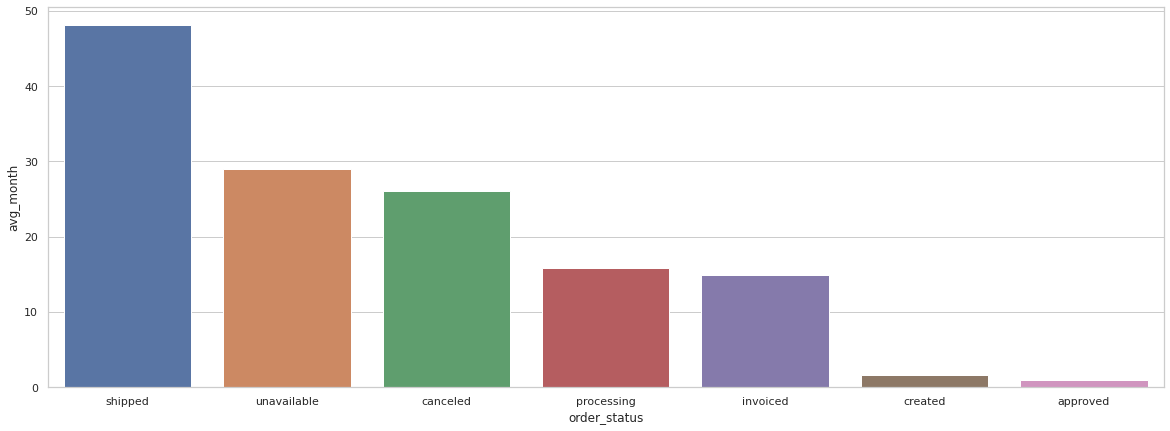

In [8]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

sns.barplot(x='order_status', y='avg_month', data=avg_month)

# график распределения avg_month 

#    3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [9]:
orders_items = orders.merge(order_items, on='order_id')

# соединение датасетов

In [10]:
orders_items.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders_items['day_of_week'] = orders_items['order_purchase_timestamp'].dt.day_name()

# формат колонки к datetime, создание колонки с днем недели

In [11]:
orders_items = orders_items.dropna()

# удаление пропущенных значений

In [12]:
orders_day = orders_items.groupby(['product_id','day_of_week'],as_index=False).\
agg({'order_id' : 'count'}).drop_duplicates(subset=["product_id"], keep='first').\
rename(columns={'order_id': 'num_of_orders'}).\
sort_values('num_of_orders', ascending=False)

# подсчет количества покупок каждого товара в каждый день недели

In [13]:
orders_day_pivot = orders_day.pivot(index='product_id', columns='day_of_week', values='num_of_orders').fillna(0)

# переворачиваем датасет

In [14]:
best_day_for_product = orders_day_pivot.idxmax(axis=1).to_frame().rename(columns={0: 'day_of_week'}).reset_index()

# по каждому товару выводим, в какой день недели товар чаще всего покупается

In [15]:
best_day_for_product.head()

,product_id,day_of_week
0,0009406fd7479715e4bef61dd91f2462,Saturday
1,000b8f95fcb9e0096488278317764d19,Monday
2,000d9be29b5207b54e86aa1b1ac54872,Monday
3,0011c512eb256aa0dbbb544d8dffcf6e,Tuesday
4,00126f27c813603687e6ce486d909d01,Friday


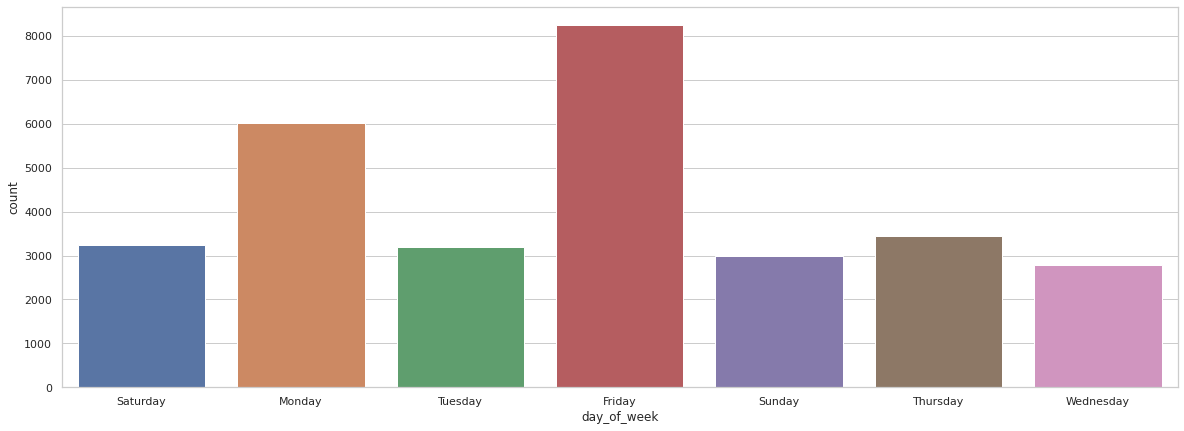

In [16]:
sns.countplot(x=best_day_for_product["day_of_week"])

# распределение количества самых популярных дней для всех товаров

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [17]:
orders_and_customers = orders.merge(customers, on='customer_id')

#соединение датасетов

In [18]:
orders_and_customers = orders_and_customers.\
loc[(orders_and_customers.order_status != 'unavailable') & (orders_and_customers.order_status != 'canceled')]

# оставляем только успешные заказы

In [19]:
orders_and_customers.order_purchase_timestamp = pd.to_datetime(orders_and_customers.order_purchase_timestamp)
orders_and_customers['year_and_month'] =  orders_and_customers.order_purchase_timestamp.dt.to_period("M") 

# формат колонки к datetime, создание колонки с годом и месяцем

In [20]:
print('Min date =',orders_and_customers.order_purchase_timestamp.min())
print('Max date =',orders_and_customers.order_purchase_timestamp.max())

# выведем первый и последний месяцы, которые будут неполными

Min date = 2016-09-04 21:15:19
Max date = 2018-09-03 09:06:57


In [21]:
orders_and_customers = orders_and_customers.query('year_and_month >= "2016-10" & year_and_month < "2018-09"')

# исключаем неполные месяцы

In [22]:
orders_and_customers = orders_and_customers.groupby(['customer_unique_id','year_and_month'],as_index=False).\
agg({'order_id' : 'count'}).\
sort_values('order_id',ascending=False).\
rename(columns={'order_id' : 'orders_count'})

# количество покупок для каждого пользователя в каждом месяце

In [23]:
orders_and_customers.head()

,customer_unique_id,year_and_month,orders_count
7232,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6
23654,3e43e6105506432c953e165fb2acf44c,2018-02,4
61450,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4
66938,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4
75870,c8460e4251689ba205045f3ea17884a1,2018-08,4


In [24]:
orders_and_customers['avg_week_orders'] = orders_and_customers.orders_count/\
((orders_and_customers.year_and_month.dt.daysinmonth)/7)

# добавим колонку с средним количеством заказов для каждого пользователя в каждую неделю

In [25]:
orders_and_customers.head()

,customer_unique_id,year_and_month,orders_count,avg_week_orders
7232,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,1.354839
23654,3e43e6105506432c953e165fb2acf44c,2018-02,4,1.000000
61450,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,1.000000
66938,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4,0.933333
75870,c8460e4251689ba205045f3ea17884a1,2018-08,4,0.903226


In [26]:
week_avg_orders = orders_and_customers.groupby('customer_unique_id',as_index=False).agg({'avg_week_orders' : 'mean'})

# сгруппируем по пользователям и выведем для каждого среднее количество заказов в неделю

In [27]:
week_avg_orders.head()

,customer_unique_id,avg_week_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,0.225806
4,0004aac84e0df4da2b147fca70cf8255,0.233333


# 5. Когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

In [28]:
orders_customers = orders.merge(customers, on='customer_id')

#соединение датасетов

In [29]:
orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [30]:
orders_customers.order_purchase_timestamp = pd.to_datetime(orders_customers.order_purchase_timestamp)
orders_customers['year_and_month'] =  orders_customers.order_purchase_timestamp.dt.to_period("M") 

# формат колонки к datetime, создание колонки с годом и месяцем

In [31]:
orders_customers = orders_customers.\
loc[(orders_customers.order_status != 'unavailable') & (orders_customers.order_status != 'canceled')]

# оставляем только успешные заказы

In [32]:
orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,year_and_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02


In [33]:
first_order = orders_customers.\
groupby('customer_unique_id',as_index=False).\
agg({'year_and_month' : 'min'}).\
rename(columns={'year_and_month' : 'first_order_date'})

# находим дату первого заказа для каждого пользователя

In [34]:
first_order.head()

,customer_unique_id,first_order_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [35]:
orders_customers = orders_customers[['order_id','customer_unique_id','year_and_month']]
cohorts = orders_customers.merge(first_order,how='inner',on='customer_unique_id')

# оставляет нужные кололнки, соединяем с датасетом даты первого заказа

In [36]:
cohorts.head()

,order_id,customer_unique_id,year_and_month,first_order_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,69923a4e07ce446644394df37a710286,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09
2,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07,2018-07
3,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
4,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11


In [37]:
cohorts = cohorts.groupby(['first_order_date','year_and_month'],as_index=False).\
agg({'customer_unique_id': 'nunique'}).\
rename(columns={'customer_unique_id': 'users'})

In [38]:
cohorts.head()

,first_order_date,year_and_month,users
0,2016-09,2016-09,2
1,2016-10,2016-10,290
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1


In [39]:
def cohort_month(df):
    df['month'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby('first_order_date').apply(cohort_month)

# функция, которая нумерует месяцы по диапазону окна в когорте

In [40]:
cohorts = cohorts.pivot_table(columns='month', index = 'first_order_date',values='users')

# развернем датасет

In [41]:
x = cohorts[1]
retention = cohorts.divide(x, axis=0).round(4)
retention[retention[3] == retention[3].max()].index

# находим когорту с самым высоким retention на 3й месяц

PeriodIndex(['2017-09'], dtype='period[M]', name='first_order_date', freq='M')

In [42]:
 retention

month,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
first_order_date,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.0034,0.0034,0.0034,0.0034,0.0034,0.0034,0.0069,0.0069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12,1.0,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.0040,0.0027,0.0013,0.0040,0.0013,0.0040,0.0013,0.0013,0.0040,0.0013,0.0066,0.0040,0.0013,0.0013,0.0027,0.0040,0.0013
2017-02,1.0,0.0024,0.0030,0.0012,0.0041,0.0012,0.0024,0.0018,0.0012,0.0018,0.0012,0.0030,0.0012,0.0018,0.0012,0.0006,0.0006,0.0024
2017-03,1.0,0.0051,0.0035,0.0039,0.0035,0.0016,0.0016,0.0031,0.0035,0.0008,0.0039,0.0012,0.0023,0.0012,0.0016,0.0023,0.0008,0.0016
2017-04,1.0,0.0060,0.0022,0.0017,0.0030,0.0026,0.0034,0.0030,0.0030,0.0017,0.0026,0.0009,0.0009,0.0004,0.0009,0.0009,0.0013,NaN
2017-05,1.0,0.0048,0.0048,0.0040,0.0031,0.0034,0.0042,0.0014,0.0025,0.0025,0.0025,0.0034,0.0025,0.0003,0.0020,0.0023,NaN,NaN
2017-06,1.0,0.0045,0.0035,0.0039,0.0026,0.0039,0.0035,0.0023,0.0013,0.0023,0.0032,0.0032,0.0016,0.0013,0.0019,NaN,NaN,NaN


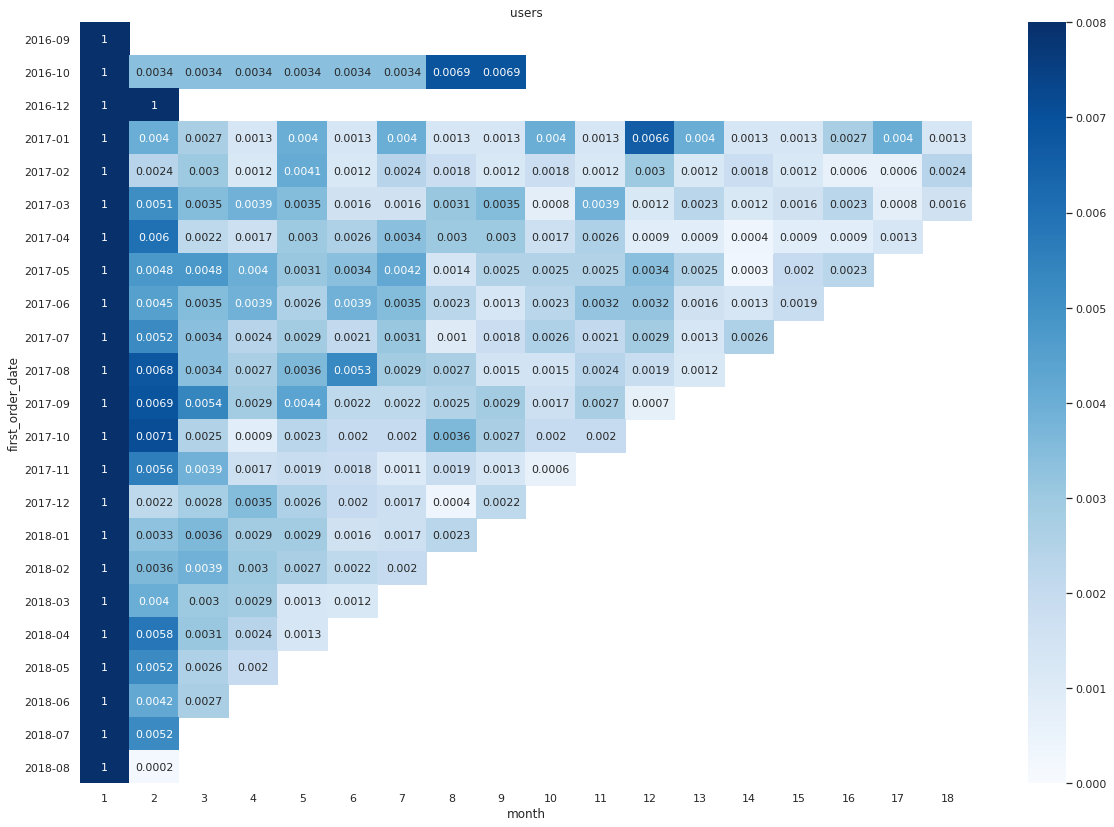

In [43]:
plt.rcParams['font.size'] = '11'
plt.figure(figsize=(20,14))
plt.title('users')
ax = sns.heatmap(data=retention, annot=True, vmin=0.0,vmax=0.008 ,cmap='Blues')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()
fig.savefig("Retention Counts.png")
plt.show()

# визуализируем

# 6. RFM-сегментация пользователей, чтобы качественно оценить свою аудиторию.

In [44]:
df_rfm = orders.merge(customers, on='customer_id').merge(order_items, on='order_id')

# объеденим все датасеты в один

In [45]:
df_rfm = df_rfm.loc[(df_rfm.order_status != 'unavailable') & (df_rfm.order_status != 'canceled')]

# оставляем только успешные заказы 

In [46]:
df_rfm.order_purchase_timestamp = pd.to_datetime(df_rfm.order_purchase_timestamp)

# формат колонки к datetime

In [47]:
df_rfm.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-07,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-11,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [48]:
current_date = df_rfm.order_purchase_timestamp.max()

# за текущую дату возьмем дату последней покупки

In [49]:
print('Текущая дата:',current_date)

Текущая дата: 2018-09-03 09:06:57


In [50]:
df_rfm = df_rfm.groupby('customer_unique_id').agg({'order_purchase_timestamp' : 'max','order_id' : 'count','price' : 'sum'})

# найдем дату последнего заказа, а также посчитаем количество заказов, обшую сумму заказов для каждого пользователя

In [51]:
df_rfm['recency'] = current_date - df_rfm.order_purchase_timestamp

# добавим колонку с временем от последней покупки пользователя до текущей даты

In [52]:
df_rfm = df_rfm.rename(columns={'order_id' : 'frequency','price' : 'monetary'})
df_rfm.head()
# переименуем колонки

,order_purchase_timestamp,frequency,monetary,recency
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,115 days 22:10:30
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,118 days 21:55:30
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,541 days 12:01:54
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,325 days 12:37:16
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,292 days 13:21:15


# Изучим полученные данные и и определим границы метрик RFM

In [53]:
df_rfm.describe()

,frequency,monetary,recency
count,94983.000000,94983.000000,94983
mean,1.180222,142.071747,243 days 01:50:53.177663368
std,0.620593,216.074999,152 days 23:35:30.269131900
min,1.000000,0.850000,0 days 00:00:00
25%,1.000000,47.900000,118 days 22:58:04
50%,1.000000,89.890000,223 days 18:48:49
75%,1.000000,155.000000,351 days 22:36:58
max,24.000000,13440.000000,728 days 11:51:38


# Recency

In [54]:
r_q25 = df_rfm.recency.quantile(0.25)
r_q50 = df_rfm.recency.quantile(0.5)
r_q75 = df_rfm.recency.quantile(0.75)

def recency_rate(recency):
    if recency < r_q25:
        return 'Н'
    elif r_q25 <= recency < r_q50:
        return 'СД'
    elif r_q50 <= recency < r_q75:
        return 'Д'
    elif recency >= r_q75:
        return 'ОД'

# функция для определения рейтинга Recency    

In [55]:
df_rfm['recenty_rate'] = df_rfm.recency.apply(lambda x: recency_rate(x))
df_rfm.head()

# применим функцию, рассчитаем рейтинг

,order_purchase_timestamp,frequency,monetary,recency,recenty_rate
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,115 days 22:10:30,Н
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,118 days 21:55:30,Н
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,541 days 12:01:54,ОД
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,325 days 12:37:16,Д
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,292 days 13:21:15,Д


# Frequency

In [56]:
df_rfm.frequency.value_counts()

1     83179
2      8950
3      1667
4       629
5       246
6       195
7        46
8        16
9        11
10       11
11       11
12        9
14        3
13        2
15        2
20        2
21        1
16        1
18        1
24        1
Name: frequency, dtype: int64

 Т.к большинство клиентов сделали одну покупку, то логично будет разбить frequency на 4 категории:
- 1 покупка
- 2 покупки
- 3 покупки
- более 3 покупок

In [57]:
def frequency_rate(frequency):
    if frequency == 1:
        return '1'
    elif frequency == 2:
        return '2'
    elif frequency == 3:
        return '3'
    elif frequency > 3:
        return '4'

# функция для определения рейтинга Frequency 

In [58]:
df_rfm['frequency_rate'] = df_rfm.frequency.apply(lambda x: frequency_rate(x))
df_rfm.head()

# применим функцию, рассчитаем рейтинг

,order_purchase_timestamp,frequency,monetary,recency,recenty_rate,frequency_rate
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,115 days 22:10:30,Н,1
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,118 days 21:55:30,Н,1
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,541 days 12:01:54,ОД,1
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,325 days 12:37:16,Д,1
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,292 days 13:21:15,Д,1


# Monetary

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


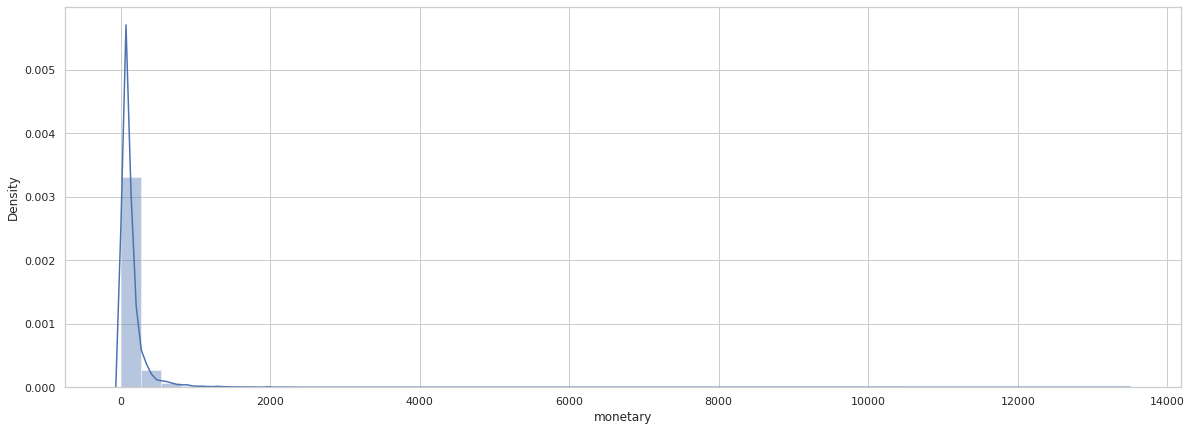

In [59]:
sns.distplot(df_rfm.monetary)

# график распределения

Распределение значений monetary отклоняются от нормального распределения.

In [60]:
df_rfm.loc[df_rfm.monetary > df_rfm.monetary.quantile(0.75)].monetary.describe()

count    23690.000000
mean       356.087592
std        348.621133
min        155.060000
25%        189.882500
50%        244.990000
75%        371.925000
max      13440.000000
Name: monetary, dtype: float64

In [61]:
df_rfm.loc[df_rfm.monetary > 371.925000].monetary.describe()

count     5923.000000
mean       742.219521
std        526.479926
min        372.000000
25%        445.095000
50%        586.560000
75%        829.495000
max      13440.000000
Name: monetary, dtype: float64

In [62]:
df_rfm.loc[df_rfm.monetary > 829.495000].monetary.describe()

count     1481.000000
mean      1371.213153
std        730.634350
min        829.990000
25%        949.990000
50%       1180.000000
75%       1559.920000
max      13440.000000
Name: monetary, dtype: float64

В связи с таким неравномерным распределение monetary, для каждой границы я буду брать значения до 75 перцентиля, затем отсекать данные (> 75 перцентиля) и снова возьму значения до 75 перцентиля.

In [63]:
m_q75_1 = df_rfm.monetary.quantile(0.75)
m_q75_2 = df_rfm.loc[df_rfm.monetary > m_q75_1].monetary.quantile(0.75)
m_q75_3 = df_rfm.loc[df_rfm.monetary > m_q75_2].monetary.quantile(0.75)
def monetary_rate(monetary):
    if monetary < m_q75_1:
        return 'М'
    elif monetary >= m_q75_1 and monetary < m_q75_2:
        return 'НС'
    elif monetary >= m_q75_2 and monetary < m_q75_3:
        return 'С'
    elif monetary >= m_q75_3:
        return 'Б'
    
# функция для определения рейтинга monetary

In [64]:
df_rfm['monetary_rate'] = df_rfm.monetary.apply(lambda x: monetary_rate(x))
df_rfm.head()
# применим функцию, рассчитаем рейтинг

,order_purchase_timestamp,frequency,monetary,recency,recenty_rate,frequency_rate,monetary_rate
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,129.90,115 days 22:10:30,Н,1,М
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1,18.90,118 days 21:55:30,Н,1,М
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,541 days 12:01:54,ОД,1,М
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1,25.99,325 days 12:37:16,Д,1,М
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1,180.00,292 days 13:21:15,Д,1,НС


In [65]:
df_rfm = df_rfm[['recency','frequency','monetary','recenty_rate','frequency_rate','monetary_rate']]

In [66]:
df_rfm['rfm'] = df_rfm.recenty_rate + ';' + df_rfm.frequency_rate + ';' +  df_rfm.monetary_rate

# объеденим рейтинги

In [67]:
df_rfm.head()

,recency,frequency,monetary,recenty_rate,frequency_rate,monetary_rate,rfm
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115 days 22:10:30,1,129.90,Н,1,М,Н;1;М
0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 21:55:30,1,18.90,Н,1,М,Н;1;М
0000f46a3911fa3c0805444483337064,541 days 12:01:54,1,69.00,ОД,1,М,ОД;1;М
0000f6ccb0745a6a4b88665a16c9f078,325 days 12:37:16,1,25.99,Д,1,М,Д;1;М
0004aac84e0df4da2b147fca70cf8255,292 days 13:21:15,1,180.00,Д,1,НС,Д;1;НС


In [68]:
df_rfm.rfm.nunique()

# количество уникальных RFM-микросегментов

64

In [69]:
df_rfm.rfm.value_counts()

Н;1;М      16268
ОД;1;М     16259
СД;1;М     16248
Д;1;М      16189
ОД;1;НС     3537
           ...  
ОД;4;Б        27
Д;3;Б         15
Н;3;Б         14
ОД;3;Б        11
СД;3;Б        10
Name: rfm, Length: 64, dtype: int64

# Составляем RFM-сегменты,основываясь в первую очередь на метрике monetary, далее на recency и frequency

In [70]:
df_rfm_value_counts = df_rfm.rfm.value_counts().to_frame().reset_index()

# датасет для визуализации графика распределения количества клиентов по микросегментам

Text(0, 0.5, 'Количество клиентов')

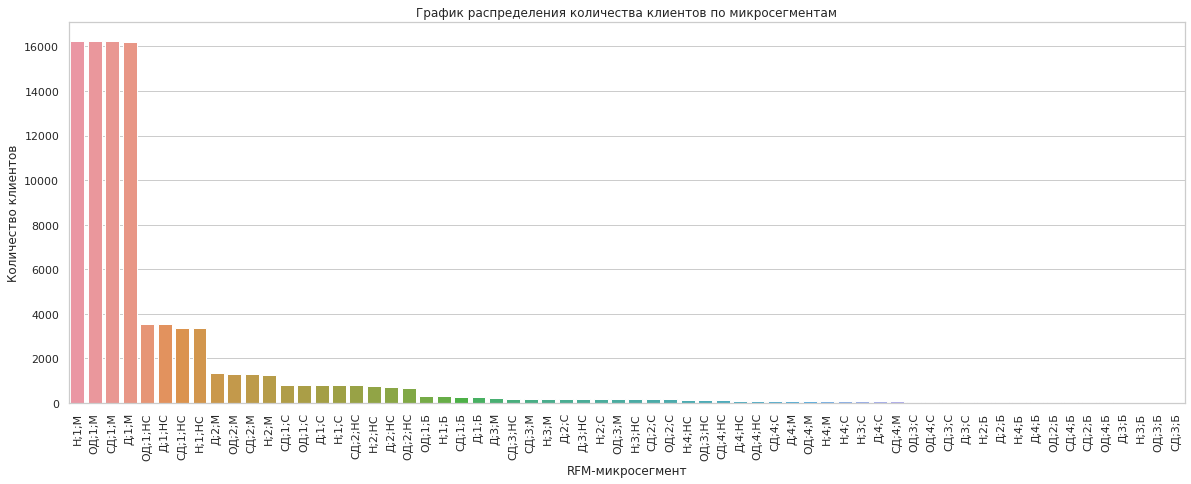

In [71]:
sns.barplot(data=df_rfm_value_counts, x='index', y='rfm')
plt.xticks(rotation=90)
plt.title('График распределения количества клиентов по микросегментам')
plt.xlabel('RFM-микросегмент')
plt.ylabel('Количество клиентов')

# строим график

In [72]:
df_rfm_monetary_sum = df_rfm.groupby('rfm',as_index=False).agg({'monetary' : 'sum'}).sort_values('monetary', ascending=False)

# датасет для визуализации графика распределения общей суммы покупок по микросегментам

Text(0, 0.5, 'Сумма покупок')

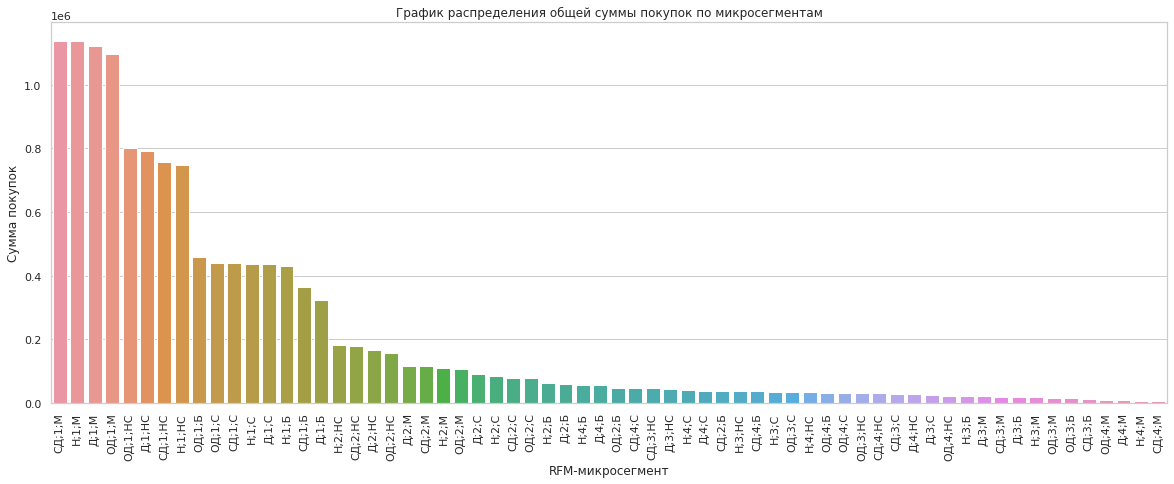

In [73]:
sns.barplot(data=df_rfm_monetary_sum, x='rfm', y='monetary')
plt.xticks(rotation=90)
plt.title('График распределения общей суммы покупок по микросегментам')
plt.xlabel('RFM-микросегмент')
plt.ylabel('Сумма покупок')

# строим график

In [74]:
def segment(monetary_rate):
    if monetary_rate == 'М':
        return 'Бюджетный'
    elif monetary_rate == 'НС' or monetary_rate == 'С':
        return 'Стандарт'
    elif monetary_rate == 'Б':
        return 'VIP'
    
# функция для определения сегмента    

In [75]:
df_rfm['segment'] = df_rfm.monetary_rate.apply(lambda x: segment(x))

# применяем функцию, рассчитываем сегмент

In [76]:
df_rfm.head()

,recency,frequency,monetary,recenty_rate,frequency_rate,monetary_rate,rfm,segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115 days 22:10:30,1,129.90,Н,1,М,Н;1;М,Бюджетный
0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 21:55:30,1,18.90,Н,1,М,Н;1;М,Бюджетный
0000f46a3911fa3c0805444483337064,541 days 12:01:54,1,69.00,ОД,1,М,ОД;1;М,Бюджетный
0000f6ccb0745a6a4b88665a16c9f078,325 days 12:37:16,1,25.99,Д,1,М,Д;1;М,Бюджетный
0004aac84e0df4da2b147fca70cf8255,292 days 13:21:15,1,180.00,Д,1,НС,Д;1;НС,Стандарт


In [77]:
df_rfm_segments_sum = df_rfm.groupby('segment',as_index=False).\
agg({'monetary' : 'sum'}).\
sort_values('monetary', ascending=False)

# датасет для визуализации графика распределения суммы покупок по сегментам

In [78]:
df_rfm_segments_sum.head()

,segment,monetary
2,Стандарт,6.416418e+06
1,Бюджетный,5.047216e+06
0,VIP,2.030767e+06


Text(0, 0.5, 'Сумма покупок')

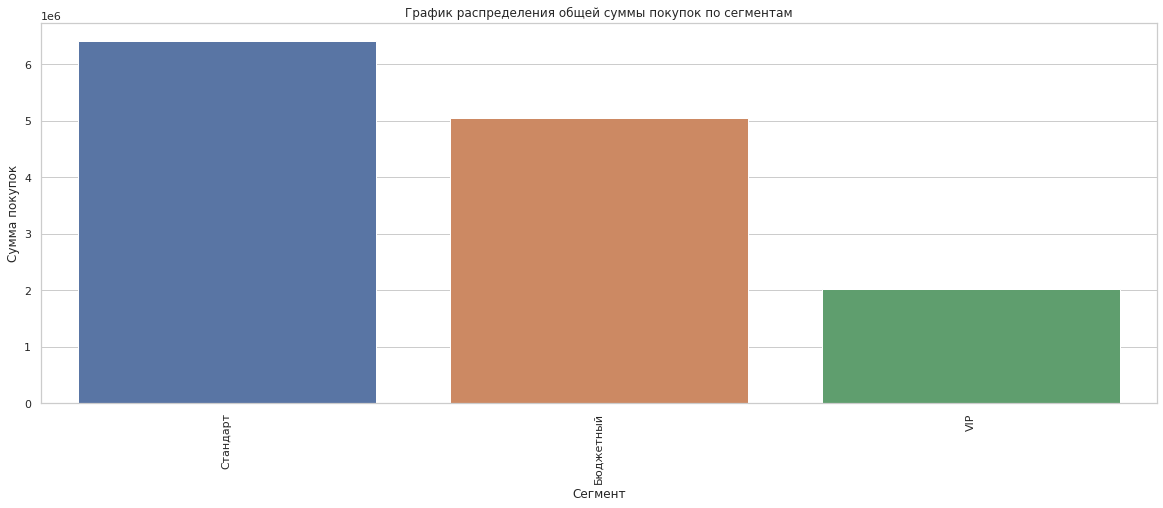

In [79]:
sns.barplot(data=df_rfm_segments_sum, x='segment', y='monetary')
plt.xticks(rotation=90)
plt.title('График распределения общей суммы покупок по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Сумма покупок')

# строим график

# Ключевые выводы по данным:

- Большинство пользователей делает не более одной покупки, нужно разработать стратегию для удержания клиентов
- Относительно небольшой доход от клиентов сегмента "VIP", нужно разработать систему лояльности
- Высокодоходные клиенты не задерживаются, нужно разработать более гибкую систему лояльности для высокодоходных клиентов